In [1]:
import numpy as np
import gym
import matplotlib.pyplot as plt
import torch
import torchvision
import cv2

In [44]:
env = gym.make('MontezumaRevengeDeterministic-v4', render_mode='rgb_array')
obs = env.reset()
obs = torch.from_numpy(obs)

In [68]:
def stateobs2latent(snapshot, obs, h=11, w=8, d=10):
    obs = obs.numpy()
    obs = obs.mean(axis=-1)
    obs = cv2.resize(obs, (w, h), interpolation=cv2.INTER_AREA)
    obs = (obs*d/255.).astype(np.uint8)
    return obs

class GoExploreAtariWrapper(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        
    def reset(self, snapshot=None):
        if snapshot is None:
            self.env.reset()
        else:
            obs, reward, done, info, snapshot = snapshot
            self.env.ale.restoreState(snapshot)
            return obs, reward, done, info
        
    def step(self, action):
        obs, reward, done, info = super().step(action)
        snapshot = self.env.ale.cloneState()
        snapshot = obs, reward, done, info, snapshot
        return snapshot, obs, reward, done, info

env = gym.make('MontezumaRevengeDeterministic-v4', render_mode='rgb_array')
env = GoExploreAtariWrapper(env)
obs = env.reset()

In [86]:
env.reset()
for i in range(100):
    env.step(env.action_space.sample())

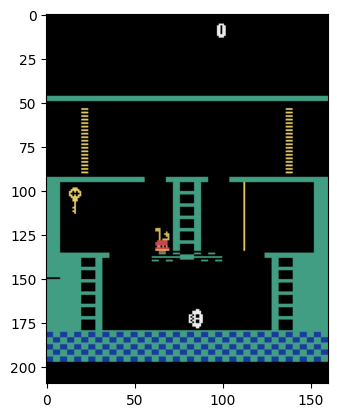

In [30]:
env.reset()
for _ in range(100):
    obs, reward, done, info = env.step(4)
snapshot = env.ale.cloneState()
plt.imshow(obs)
plt.show()

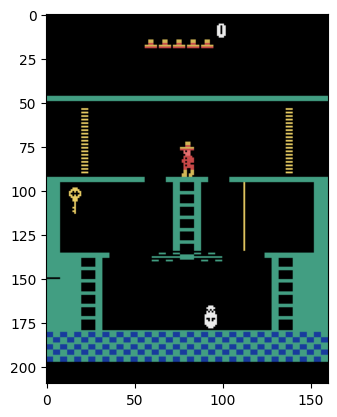

In [32]:
obs = env.reset()
plt.imshow(obs)
plt.show()

In [35]:
env.ale.restoreState(snapshot)

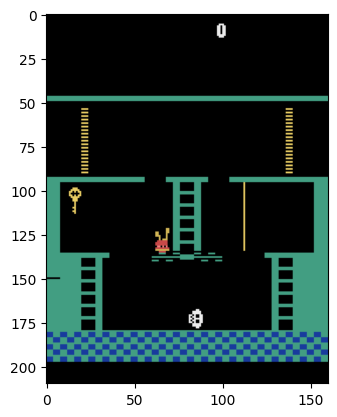

In [37]:
obs, reward, done, info = env.step(0)
plt.imshow(obs)
plt.show()

In [ ]:
env.unwrapped.get_action_meanings()

['NOOP',
 'FIRE',
 'UP',
 'RIGHT',
 'LEFT',
 'DOWN',
 'UPRIGHT',
 'UPLEFT',
 'DOWNRIGHT',
 'DOWNLEFT',
 'UPFIRE',
 'RIGHTFIRE',
 'LEFTFIRE',
 'DOWNFIRE',
 'UPRIGHTFIRE',
 'UPLEFTFIRE',
 'DOWNRIGHTFIRE',
 'DOWNLEFTFIRE']

In [16]:
env.action_space

Discrete(18)

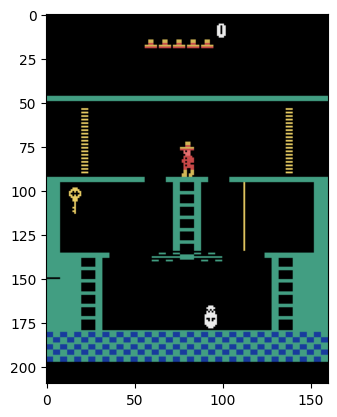

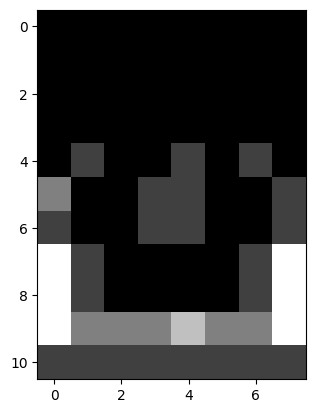

In [6]:

plt.imshow(obs)
plt.show()
plt.imshow(obs2latent(obs), cmap='gray')
plt.show()

In [6]:
obs2latent(obs)

array([[0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 1, 0, 1, 0],
       [2, 0, 0, 1, 1, 0, 0, 1],
       [1, 0, 0, 1, 1, 0, 0, 1],
       [4, 1, 0, 0, 0, 0, 1, 4],
       [4, 1, 0, 0, 0, 0, 1, 4],
       [4, 2, 2, 2, 3, 2, 2, 4],
       [1, 1, 1, 1, 1, 1, 1, 1]])

(1) the original frame is converted to grayscale, (2) its resolution is reduced with pixel area
relation interpolation to a width w ≤ 160 and a height h ≤ 210, and (3) the pixel depth is reduced to d ≤ 255 using
the formula b
d·p
255 c, where p is the value of the pixel after step (2).

In [26]:
env.action_space

Discrete(18)

In [27]:
env.observation_space

Box(0, 255, (210, 160, 3), uint8)

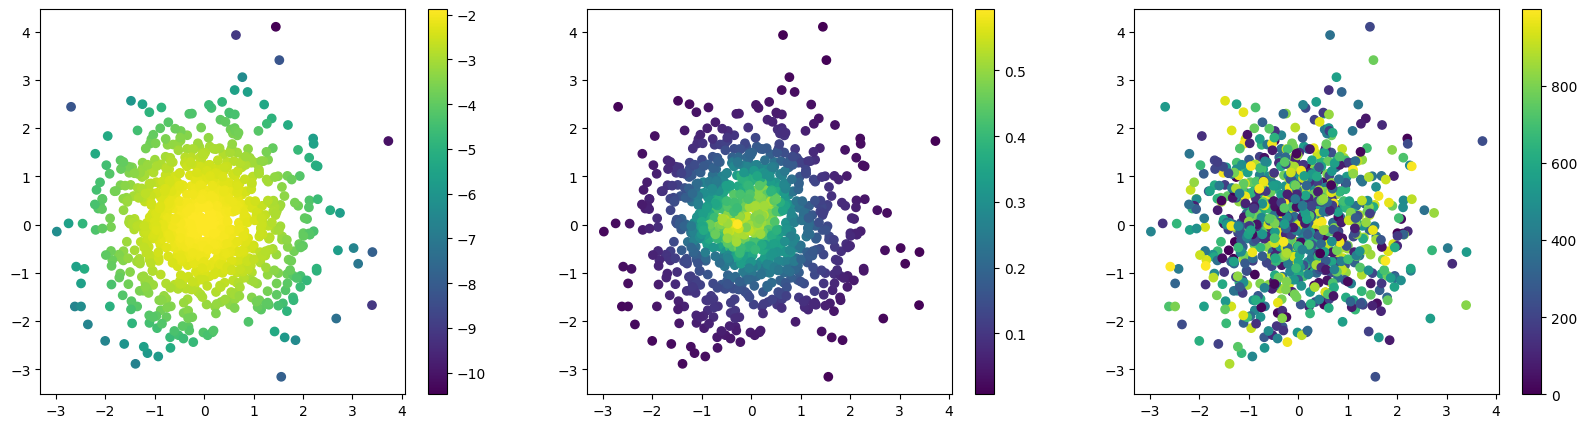

In [116]:
import sklearn.mixture

def gaussian_density(q):
    gm = sklearn.mixture.GaussianMixture(n_components=1)
    gm = gm.fit(x.numpy())
    return torch.from_numpy(gm.score_samples(q.numpy()))

def other_density(q):
    n, d = x.shape
    k = int(2.*(n**(1./d)))
    dist = (q[:, None]-x[None, :]).norm(dim=-1)
    dist = dist.sort(dim=-1).values[:, k]
    idist = dist**-d
    density = k/n*idist
    return density
def other_density2(q, p=.1):
    density = other_density(q)
    ranks = density.argsort()
    return ranks
    # density = p*(1.-p)**ranks
    # density = density/density.sum()
    # return density

torch.manual_seed(0)
x = torch.randn(1000, 2)


plt.figure(figsize=(20, 5))
plt.subplot(131)
d = gaussian_density(x)
plt.scatter(*x.numpy().T, c=d.numpy())
plt.colorbar()
plt.subplot(132)
d = other_density(x)
plt.scatter(*x.numpy().T, c=d.numpy())
plt.colorbar()
plt.subplot(133)
d = other_density2(x, p=0.001)
plt.scatter(*x.numpy().T, c=d.numpy())
plt.colorbar()

plt.show()